For introduction and problem statement, please refer to notebook 1

## Content

**Notebook 1: 1_data_cleaning_and_eda**
- Data Import and Cleaning
- Exploratory Data Analysis
- Text Data Pre-processing

**Notebook 2: 2_topic modelling**
- Data Import
- Topic Modelling with Gensim

**Notebook 3: 3_topic_analysis_and_visualizations**
- [Findings and Analysis of Topic Modelling](#Findings-and-Analysis-of-Topic-Modelling)

**Notebook 4: 4_features_extractions_and_sentiment_analysis**
- Data Import
- Sentiment Analysis with VADER
- Sentiment Analysis with Logistic Regression(Multi-Class Classification)
- Evaluation of Sentiment Analysis with BERT(Multi-Class Classification)
Please refer to notebook 5 for the fine-tuning process of pre-trained BERT model


**Notebook 5: 5_fine_tuning_of_BERT_model**   
The reason why this notebook is separated from notebook 4 which contains the evaluation of BERT model is because the fine-tuning of BERT model requires GPU. Hence, the model was fine-tuned on Google Colaboratory and loaded back into notebook 4 for evaluation


**Notebook 6: 6_analysis_and_findings**
- Comparison of the 3 Methods 
- Recommendation and Conclusion 
- Future Steps

## Findings and Analysis of Topic Modelling

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords 
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from pprint import pprint
import pickle
#pd.options.display.max_colwidth = 150

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
#reading in the main dataframe
new_reviews = pd.read_csv('../data/cleaned_combined_data.csv',na_filter=False)

In [3]:
#reading in the lda model that we have selected from notebook 2
best_model = pickle.load(open('../data/best_topic_model_v2.pkl', 'rb'))

In [4]:
# reading in the data format that we have prepared in notebook 2
data_ready = pickle.load(open('../data/data_ready_v2.data', 'rb'))

In [5]:
new_reviews.shape

(67947, 21)

In [6]:
len(data_ready)

67947

In [7]:
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.083*"work" + 0.065*"card" + 0.031*"sim" + 0.023*"wifi" + 0.022*"network" '
  '+ 0.020*"need" + 0.016*"set" + 0.014*"carrier" + 0.014*"datum" + '
  '0.012*"issue"'),
 (1,
  '0.149*"work" + 0.047*"brand" + 0.044*"condition" + 0.036*"seller" + '
  '0.034*"purchase" + 0.029*"arrive" + 0.025*"refurbish" + 0.025*"thank" + '
  '0.025*"well" + 0.023*"price"'),
 (2,
  '0.029*"call" + 0.020*"say" + 0.017*"return" + 0.014*"receive" + 0.013*"try" '
  '+ 0.013*"could" + 0.012*"review" + 0.011*"service" + 0.011*"tell" + '
  '0.011*"unlock"'),
 (3,
  '0.034*"screen" + 0.019*"camera" + 0.015*"app" + 0.011*"case" + 0.010*"time" '
  '+ 0.009*"take" + 0.008*"thing" + 0.008*"feel" + 0.008*"video" + '
  '0.007*"display"'),
 (4,
  '0.082*"love" + 0.073*"price" + 0.041*"camera" + 0.035*"quality" + '
  '0.030*"note" + 0.023*"value" + 0.023*"feature" + 0.014*"picture" + '
  '0.014*"money" + 0.013*"better"'),
 (5,
  '0.070*"work" + 0.054*"month" + 0.040*"issue" + 0.038*"problem" + '
  '0.026*"screen" 

In [8]:
#recreate dictionary and corpus as we need these information to feed into the function below
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(line) for line in data_ready]

In [9]:
len(corpus)

67947

In [10]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Initialise output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data_ready)

In [11]:
# Format
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['overall_dom_topic', 'topic_perc_contrib', 'keywords', 'text']
df_dominant_topic.head(10)

,overall_dom_topic,topic_perc_contrib,keywords,text
0,3.0,0.6844,"screen, camera, app, case, time, take, thing, ...","[awhile, review, detect, rage, thing, finally,..."
1,2.0,0.5159,"call, say, return, receive, try, could, review...","[text, messaging, work, software, issue, messa..."
2,3.0,0.6546,"screen, camera, app, case, time, take, thing, ...","[purchase, die, menu, easily, speed, dialing, ..."
3,2.0,0.4367,"call, say, return, receive, try, could, review...","[love, love, need, price, bill, receive, month..."
4,3.0,0.4316,"screen, camera, app, case, time, take, thing, ...","[service, option, case, purpose, offer, day, c..."
5,3.0,0.3397,"screen, camera, app, case, time, take, thing, ...","[work, decide, problem, battery, case, fish, c..."
6,3.0,0.3484,"screen, camera, app, case, time, take, thing, ...","[cool, color, word, describe, perfectly, mean,..."
7,0.0,0.3646,"work, card, sim, wifi, network, need, set, car...","[headset, overall, headset, call, tech, suppor..."
8,3.0,0.4203,"screen, camera, app, case, time, take, thing, ...","[never, first, alot, reception, signal, streng..."
9,3.0,0.4434,"screen, camera, app, case, time, take, thing, ...","[bit, school, need, text, messaging, month, te..."


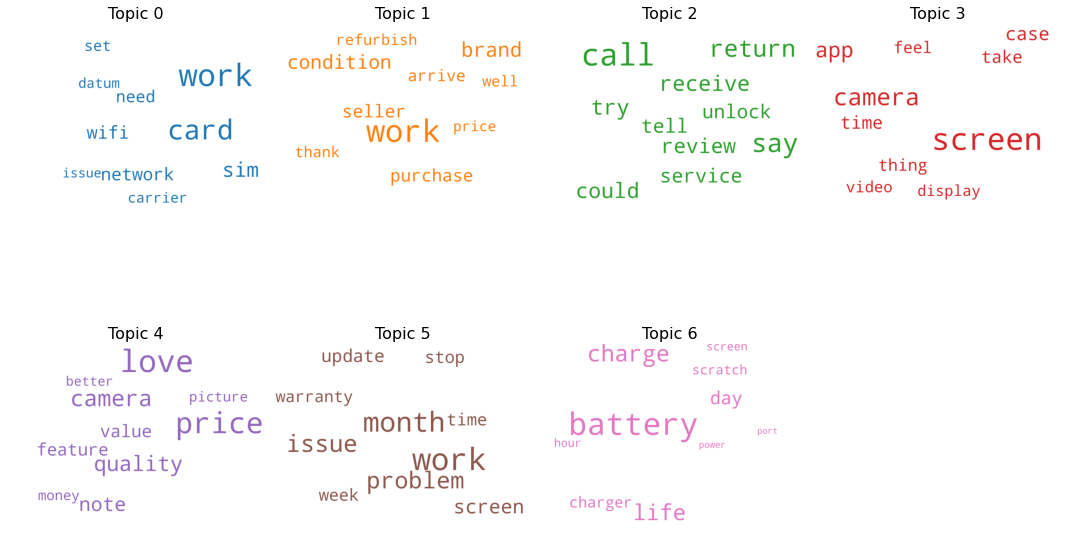

In [12]:
#Wordcloud of top 10 words in each topic
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#show models topics
topics = best_model.show_topics(formatted=False)

#create subplot
fig, axes = plt.subplots(2, 4, figsize=(15,15))
axes = axes.ravel()
axes[7].set_visible(False)

#looping through the subplot to plot each topic
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    if i>=6:
        break

#adjust the subplot settings 
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=-30)
plt.show()


The topic model performed relatively well, as we can see from the coherence score, as well as the word cloud. It is pretty easy to identify the topic name from the wordcloud except for topic 2. For example, **Topic 0 talks about simcard and network** while **topic 1 talks about seller.** However, I am not exactly sure what topic 2 is saying. We probably need to examine topic 2 further. The rest is pretty straightforward: **Topic 3 - screen and camera, Topic 4 - price and quality, Topic 5 - problems with the phone, Topic 6 - battery and charger**.

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary=best_model.id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.134643 -0.001709       1        1   8.831198
1      0.314833 -0.121175       2        1   6.339388
2     -0.014325  0.102689       3        1  18.936115
3     -0.201430 -0.019385       4        1  33.643005
4     -0.158067 -0.301504       5        1  11.678383
5      0.085258  0.175380       6        1   9.886740
6     -0.160913  0.165704       7        1  10.685168, topic_info=        Term          Freq         Total Category  logprob  loglift
88      work  26027.000000  26027.000000  Default  30.0000  30.0000
5    battery  16765.000000  16765.000000  Default  29.0000  29.0000
155     love  10136.000000  10136.000000  Default  28.0000  28.0000
11    charge   8184.000000   8184.000000  Default  27.0000  27.0000
139    price  11253.000000  11253.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
156     need    719.234619   6173.391602   Topic7  -5.0614   0.0865
537      run    510.809601   2707.715576   Topic7  -5.4036   0.5684
76     thing    519.426208   5267.328125   Topic7  -5.3868  -0.0802
159    still    487.946106   5855.767578   Topic7  -5.4494  -0.2487
202  include    476.874146   1981.857422   Topic7  -5.4723   0.8118

[476 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
368       1  0.057259  absolutely
368       2  0.097847  absolutely
368       3  0.010872  absolutely
368       5  0.697253  absolutely
368       6  0.107270  absolutely
...     ...       ...         ...
276       6  0.427727        year
276       7  0.052060        year
1748      6  0.995721   yesterday
2566      5  0.997984     youtube
1985      2  0.978382        zone

[898 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

From the above visualisation, we can see that there is no overlap between the topics which is also another indicator that the model has successfully grouped the topic clusters. Note that the topic number here starts from 1 while the the default output from the model starts from topic 0. Topic 1 here represents Topic 0, Topic 2 represents Topic 1 and so on.

In [14]:
combined_df = pd.concat([df_dominant_topic,new_reviews],axis=1)

Since, there was an ambiguity in topic 2 from the wordcloud that we saw earlier, let's filter some reviews out and see what they are about.

In [15]:
pd.set_option('display.max_colwidth',None)
combined_df[combined_df['overall_dom_topic'] == 2.0]['reviews'].sample(5)

23411                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Auwe! Very disappointed! I paid for a brand new phone and when I had problems with it I found that it was actually previously used and a year old.
36837    Absolute garbage. I have to keep this phone on the charger all day. It dies at 20% battery. When I try to make phone calls, the phone freezes. When I try to answer calls it freezes. It has fits where it will shut off by itself and I have to hold down the power button for like 15 seconds for it to come back on, only for it to shut off again 30 seconds later. It's extrem

The topic above seems pretty ambiguous. I would consider grouping them together with Topic 1 (Seller Topic) as many of the reviews talk about service and sellers. Alternatively, we can create a topic called "others" to park other reviews here.
 

Conclusion from topic modelling:

With this topic model, we can easily segregrate reviews by topics to improve customers experience while reading through reviews. Customers are able to quickly filter through the topics that are important to them. We can deploy this by creating multiple tabs which represent topic name. Consumers who are interested to learn more about the product can easily filter reviews that are relevant to them by clicking on the tab. 